In [1]:
import numpy as np
import astropy.units as u
from astropy.coordinates import Distance
from astropy.table import Table
from sherpa.models import model
from sherpa import data
import matplotlib.pyplot as plt
from sherpa.fit import Fit
from sherpa.stats import Chi2
from sherpa.optmethods import LevMar

from agnpy.spectra import LogParabola


In [2]:
# There is a lot of overlapping X-ray data, let us define a function to rebin the spectral points.
# We'll just perform the mean of the flux points in a bin weighted with their errors.
def rebin_sed(nu, nuFnu, nuFnu_err, nu_bins):
    """rebin the SED"""
    nu_bins_ctr = []
    nuFnu_binned = []
    nuFnu_err_binned = []
    for i in range(len(nu_bins) - 1):
        nu_min, nu_max = nu_bins[i], nu_bins[i + 1]
        # which points in this bin?
        condition = (nu_min <= nu) * (nu <= nu_max)
        # go to the next bin if there are no spectral points in this
        if not np.any(condition):
            continue
        else:
            y = nuFnu[condition]
            y_err = nuFnu_err[condition]
            y_new = np.sum(y / np.power(y_err, 2)) / np.sum(np.power(y_err, -2))
            y_err_new = 1 / np.sqrt(np.sum(np.power(y_err, -2)))
            nu_bins_ctr.append(np.sqrt(nu_min * nu_max))
            nuFnu_binned.append(y_new)
            nuFnu_err_binned.append(y_err_new)
    return (
        np.asarray(nu_bins_ctr),
        np.asarray(nuFnu_binned),
        np.asarray(nuFnu_err_binned),
    )

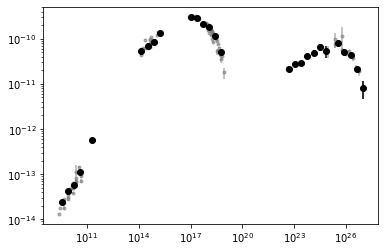

In [3]:
# read the 1D data
sed_table = Table.read("data/sed_mrk421.ecsv")
x = sed_table["x"]
y = sed_table["y"] 
y_err = sed_table["dy"]
# rebin
nu_bins = np.logspace(9, 30, 60)
x_new, y_new, y_err_new = rebin_sed(x, y, y_err, nu_bins)

plt.errorbar(x, y, yerr=y_err, ls="", marker=".", color="gray", alpha=0.6)
plt.errorbar(x_new, y_new, yerr=y_err_new, ls="", marker="o", color="k")
plt.yscale("log")
plt.xscale("log")
plt.show()

In [4]:
# load them in a sherpa data object
sed = data.Data1D("sed", x_new, y_new, staterror=y_err_new)
print(sed)

name      = sed
x         = Float64[27]
y         = Float64[27]
staterror = Float64[27]
syserror  = None


# Standard Fit

In [15]:
from agnpy.synchrotron import Synchrotron
from agnpy.compton import SynchrotronSelfCompton

In [13]:
class LogParabolaSSC(model.RegriddableModel1D):
    """wrapper of agnpy.synchrotron"""

    def __init__(self, name="lp_synch"):
        self.k_e = model.Parameter(name, "k_e", 1e-11, min=1e-15, max=1e-3)
        self.p = model.Parameter(name, "p", 2.1, min=1.0, max=5.0)
        self.q = model.Parameter(name, "q", 0.1, min=-2.0, max=2.0)
        self.gamma_0 = model.Parameter(name, "gamma_0", 1e3, min=1e2, max=1e6)
        self.gamma_min = model.Parameter(name, "gamma_min", 10, min=1, max=1e3)
        self.gamma_max = model.Parameter(name, "gamma_max", 1e5, min=1e4, max=1e9)
        self.z = model.Parameter(name, "z", 0.1, min=0.01, max=1)
        self.d_L = model.Parameter(name, "d_L", 1e27, min=1e25, max=1e33)
        self.delta_D = model.Parameter(name, "delta_D", 10, min=0, max=50)
        self.B = model.Parameter(name, "B", 2, min=0.001, max=10)
        self.R_b = model.Parameter(name, "R_b", 1e16, min=1e14, max=1e18)

        model.RegriddableModel1D.__init__(self, name,
                                          (self.k_e,
                                           self.p,
                                           self.q,
                                           self.gamma_0,
                                           self.gamma_min, self.gamma_max,
                                           self.z, self.d_L, self.delta_D,
                                           self.B, self.R_b))

    def calc(self, pars, x):
        """Evaluate the model"""
        (k_e, p, q, gamma_0, gamma_min, gamma_max,z, d_L, delta_D, B, R_b) = pars
        # add units
        k_e *= u.Unit("cm-3")
        d_L *= u.cm
        B *= u.G
        R_b *= u.cm
        x *= u.Hz

        sed_synch = Synchrotron.evaluate_sed_flux(
            x, z,
            d_L, delta_D,
            B, R_b,
            LogParabola, k_e, p, q,
            gamma_0,
            gamma_min, gamma_max
        )

        sed_ssc = SynchrotronSelfCompton.evaluate_sed_flux(
            x, z,
            d_L, delta_D,
            B, R_b,
            LogParabola, k_e, p, q,
            gamma_0,
            gamma_min, gamma_max
        )
        return sed_synch + sed_ssc

    def get_params(self):
        return (self.k_e, self.p, self.q,
                self.gamma_0, self.gamma_min, self.gamma_max,
                                           self.z, self.d_L, self.delta_D,
                                           self.B, self.R_b)

In [16]:
%%time

# define the model
model_ssc = LogParabolaSSC()
#model_ssc = LogParabolaSSCJit()
# freeze some of the parameters
R_b = 1e15 * u.cm
z = 0.0308
d_L = Distance(z=z).to("cm")
# load the fixed parameters and freeze them
model_ssc.delta_D = 21
model_ssc.delta_D.freeze()
model_ssc.z = z
model_ssc.z.freeze()
model_ssc.d_L = d_L.cgs.value
model_ssc.d_L.freeze()
model_ssc.R_b = R_b.cgs.value
model_ssc.R_b.freeze()
model_ssc.gamma_0 = 5e4
model_ssc.gamma_0.freeze()
model_ssc.gamma_min = 10
model_ssc.gamma_min.freeze()
model_ssc.gamma_max = 1e8
model_ssc.gamma_max.freeze()
print(model_ssc)

# fit!
fitter = Fit(sed, model_ssc, stat=Chi2(), method=LevMar())
min_x = 1e15
max_x = 1e30
sed.notice(min_x, max_x)
print(fitter)
res = fitter.fit()
print("\n** fit succesful?", res.succeeded)
print(res.format())

lp_synch
   Param        Type          Value          Min          Max      Units
   -----        ----          -----          ---          ---      -----
   lp_synch.k_e thawed        1e-11        1e-15        0.001           
   lp_synch.p   thawed          2.1            1            5           
   lp_synch.q   thawed          0.1           -2            2           
   lp_synch.gamma_0 frozen        50000          100        1e+06           
   lp_synch.gamma_min frozen           10            1         1000           
   lp_synch.gamma_max frozen        1e+08        10000        1e+09           
   lp_synch.z   frozen       0.0308         0.01            1           
   lp_synch.d_L frozen  4.30448e+26        1e+25        1e+33           
   lp_synch.delta_D frozen           21            0           50           
   lp_synch.B   thawed            2        0.001           10           
   lp_synch.R_b frozen        1e+15        1e+14        1e+18           
data      = sed
model 

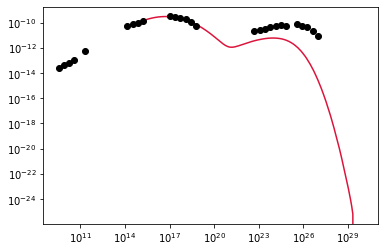

In [17]:
# plot the results
x = np.logspace(np.log10(min_x), np.log10(max_x), 200)
plt.errorbar(sed.x, sed.y, yerr=sed.staterror, marker="o", ls="", color="k")
plt.plot(x, model_ssc(x), ls="-", color="crimson")
plt.xscale("log")
plt.yscale("log")
plt.show()

# Fit with Jit

In [5]:
from agnpy.synchrotron.synchrotron_jit import SynchrotronJit
from agnpy.compton import SynchrotronSelfComptonJit

In [6]:
class LogParabolaSSCJit(model.RegriddableModel1D):
    """wrapper of agnpy.synchrotron"""

    def __init__(self, name="lp_synch"):
        self.k_e = model.Parameter(name, "k_e", 1e-11, min=1e-15, max=1e-3)
        self.p = model.Parameter(name, "p", 2.1, min=1.0, max=5.0)
        self.q = model.Parameter(name, "q", 0.1, min=-2.0, max=2.0)
        self.gamma_0 = model.Parameter(name, "gamma_0", 1e3, min=1e2, max=1e6)
        self.gamma_min = model.Parameter(name, "gamma_min", 10, min=1, max=1e3)
        self.gamma_max = model.Parameter(name, "gamma_max", 1e5, min=1e4, max=1e9)
        self.z = model.Parameter(name, "z", 0.1, min=0.01, max=1)
        self.d_L = model.Parameter(name, "d_L", 1e27, min=1e25, max=1e33)
        self.delta_D = model.Parameter(name, "delta_D", 10, min=0, max=50)
        self.B = model.Parameter(name, "B", 2, min=0.001, max=10)
        self.R_b = model.Parameter(name, "R_b", 1e16, min=1e14, max=1e18)

        model.RegriddableModel1D.__init__(self, name,
                                          (self.k_e,
                                           self.p,
                                           self.q,
                                           self.gamma_0,
                                           self.gamma_min, self.gamma_max,
                                           self.z, self.d_L, self.delta_D,
                                           self.B, self.R_b))

    def calc(self, pars, x):
        """Evaluate the model"""
        (k_e, p, q, gamma_0, gamma_min, gamma_max,z, d_L, delta_D, B, R_b) = pars
        # add units
        k_e *= u.Unit("cm-3")
        d_L *= u.cm
        B *= u.G
        R_b *= u.cm
        x *= u.Hz

        sed_synch = SynchrotronJit.evaluate_sed_flux(
            x, z,
            d_L, delta_D,
            B, R_b,
            LogParabola, k_e, p, q,
            gamma_0,
            gamma_min, gamma_max
        )

        sed_ssc = SynchrotronSelfComptonJit.evaluate_sed_flux(
            x, z,
            d_L, delta_D,
            B, R_b,
            LogParabola, k_e, p, q,
            gamma_0,
            gamma_min, gamma_max
        )
        return sed_synch + sed_ssc

    def get_params(self):
        return (self.k_e, self.p, self.q,
                self.gamma_0, self.gamma_min, self.gamma_max,
                                           self.z, self.d_L, self.delta_D,
                                           self.B, self.R_b)

In [10]:
%%time 

# define the model
model_ssc_jit = LogParabolaSSCJit()
#model_ssc = LogParabolaSSCJit()
# freeze some of the parameters
R_b = 1e15 * u.cm
z = 0.0308
d_L = Distance(z=z).to("cm")
# load the fixed parameters and freeze them
model_ssc_jit.delta_D = 21
model_ssc_jit.delta_D.freeze()
model_ssc_jit.z = z
model_ssc_jit.z.freeze()
model_ssc_jit.d_L = d_L.cgs.value
model_ssc_jit.d_L.freeze()
model_ssc_jit.R_b = R_b.cgs.value
model_ssc_jit.R_b.freeze()
model_ssc_jit.gamma_0 = 5e4
model_ssc_jit.gamma_0.freeze()
model_ssc_jit.gamma_min = 10
model_ssc_jit.gamma_min.freeze()
model_ssc_jit.gamma_max = 1e8
model_ssc_jit.gamma_max.freeze()
print(model_ssc_jit)


# fit!
fitter = Fit(sed, model_ssc_jit, stat=Chi2(), method=LevMar())
min_x = 1e15
max_x = 1e30
sed.notice(min_x, max_x)
print(fitter)
res = fitter.fit()
print("\n** fit succesful?", res.succeeded)
print(res.format())

lp_synch
   Param        Type          Value          Min          Max      Units
   -----        ----          -----          ---          ---      -----
   lp_synch.k_e thawed        1e-11        1e-15        0.001           
   lp_synch.p   thawed          2.1            1            5           
   lp_synch.q   thawed          0.1           -2            2           
   lp_synch.gamma_0 frozen        50000          100        1e+06           
   lp_synch.gamma_min frozen           10            1         1000           
   lp_synch.gamma_max frozen        1e+08        10000        1e+09           
   lp_synch.z   frozen       0.0308         0.01            1           
   lp_synch.d_L frozen  4.30448e+26        1e+25        1e+33           
   lp_synch.delta_D frozen           21            0           50           
   lp_synch.B   thawed            2        0.001           10           
   lp_synch.R_b frozen        1e+15        1e+14        1e+18           
data      = sed
model 

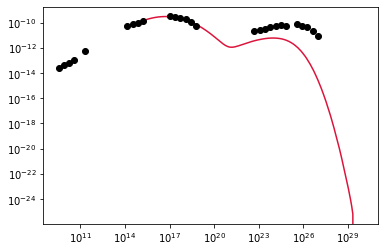

In [11]:
# plot the results
x = np.logspace(np.log10(min_x), np.log10(max_x), 200)
plt.errorbar(sed.x, sed.y, yerr=sed.staterror, marker="o", ls="", color="k")
plt.plot(x, model_ssc_jit(x), ls="-", color="crimson")
plt.xscale("log")
plt.yscale("log")
plt.show()